In [134]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from opencage.geocoder import OpenCageGeocode
import folium
import re
from staticmap import StaticMap, CircleMarker
from IPython.display import display
from PIL import Image
import io
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import time

In [2]:
df = pd.DataFrame(pd.read_csv("../assets/normalized_pyramid_data.csv"))

In [3]:
key = ['unknown', 'pyramid?']
complexes = df[~df['pyramid_complex'].isin(key)]
kings_and_queens = complexes.groupby(['pyramid_complex', 'royal_status'], sort=False).size().reset_index(name='count')

confirmed_count_fig = px.bar(kings_and_queens, 
             x='pyramid_complex', 
             y='count', 
             color='royal_status',
             title='Number of Confirmed Pyramids At Each Complex',
             labels={
                 'pyramid_complex': 'Pyramid Complex',
                 'count': 'Number of Pyramids',
                 'royal_status': 'Royal Status'
             },
             custom_data=['royal_status'])
confirmed_count_fig.update_traces(
    hovertemplate='<br>'.join([
        'Royal status: %{customdata[0]}',
        'Pyramid Complex: %{x}',
        'Total: %{y}',
        '<extra></extra>'
    ])
)
confirmed_count_fig.show()
df

,pyramid_owner,pyramid_complex,royal_status,daughter_of,royal_mother_title,likely_wife,wife_title,vizier,regent,relationship_to_king,...,site_or_location,orientation,casing,state_of_completion,superstructure_type,height,length,width,angle,notes
0,Djoser,Djoser,King,NaN,False,False,False,False,False,NaN,...,Saqqara,N-S,Limestone,NaN,Pyramid,59.9,120.00,108.00,74,"15 gates, white limestone casing"
1,Sekhemkhet,Sekhemkhet,King,NaN,False,False,False,False,False,NaN,...,Saqqara,N-S,Limestone,Unfinished,Pyramid,70,120.00,120.00,71-75,"niched facade, unfinished, left with rough ext..."
2,Nebka?,Nebka?,King,NaN,False,False,False,False,False,NaN,...,Zawiyet el-Aryan,E-W,Unknown,Unfinished,Pyramid,NaN,200.00,200.00,unknown,debate over whether this is Pyramid of Nebka
3,Khaba,Khaba,King,NaN,False,False,False,False,False,NaN,...,Zawiyet el-Aryan,E-W,Unknown,Unfinished,Pyramid,42,83.80,83.80,unknown,began as step pyramid
4,Sneferu,Sneferu 1,King,NaN,False,False,False,False,False,NaN,...,Meidum,E-W,Limestone,Unfinished,Pyramid,94.5,144.32,144.32,52,"limestone casing, causeway 200m, Cult Pyramid ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Neferkaure,unknown,King,NaN,False,False,False,False,False,NaN,...,Unknown,NaN,Unknown,Unknown,Unknown,NaN,NaN,NaN,NaN,NaN
68,Neferkauhor?,pyramid?,King,NaN,False,False,False,False,False,NaN,...,Unknown,NaN,Unknown,Unknown,Unknown,NaN,NaN,NaN,NaN,"no archaeological evidence of a pyramid, but i..."
69,Neferirkare,unknown,King,NaN,False,False,False,False,False,NaN,...,Unknown,NaN,Unknown,Unknown,Unknown,NaN,NaN,NaN,NaN,NaN
70,Wadjkare? (Demedjibtawj),pyramid?,King,NaN,False,False,False,False,False,NaN,...,Unknown,NaN,Unknown,Unknown,Unknown,NaN,NaN,NaN,NaN,"no archaeological evidence of a pyramid, but i..."


In [49]:
dynasty_pyramids = df.groupby(['dynasty', 'royal_status'], sort=False).size().reset_index(name='count')
dynasty_count_fig = px.bar(dynasty_pyramids, 
             x='dynasty', 
             y='count', 
             color='royal_status',
             title='Number of Pyramids Per Dynasty',
             labels={
                 'dynasty': 'Dynasty',
                 'count': 'Number of Pyramids (Including Speculations)',
                 'royal_status': 'Royal Status'
             },
             custom_data=['royal_status'])
dynasty_count_fig.update_traces(
    hovertemplate='<br>'.join([
        'Royal status: %{customdata[0]}',
        'Dynasty: %{x}',
        'Total: %{y}',
        '<extra></extra>'
    ])
)
dynasty_count_fig.show()

In [50]:
# Attempting to recreate George's suggested visualization (picture on my phone)

# Trying to fill 'start_of_reign' fully so that sorts work correctly
# TODO: Add this functionality to the cleanup script
unique_comp = complexes['pyramid_complex'].unique()
temp = df

for comp in unique_comp:
    start = temp[temp['pyramid_complex'] == comp]['start_of_reign'].max()
    temp[temp['pyramid_complex'] == comp]['start_of_reign'] = temp[temp['pyramid_complex'] == comp]['start_of_reign'].replace(np.nan, start)

temp.loc[temp['pyramid_complex'] == 'Sneferu 3', 'start_of_reign'] = 2574   # This had to be done to get it in the correct order (value was missing)
temp.dropna(subset='height', inplace=True)
temp.sort_values(by='start_of_reign', ascending=False, inplace=True)

# Getting the height column to be numeric
def average_of_two(val):
    if isinstance(val, int) or isinstance(val, float) or pd.isna(val): return val

    if ',' in val: return 72    # Temporary: Deals with that one weird value

    nums = val.split('-')
    if len(nums) == 1: return float(nums[0])
    return (float(nums[0]) + float(nums[1])) / 2

temp['height'] = temp['height'].map(average_of_two).astype(float)
tl = temp[['pyramid_complex', 'pyramid_owner', 'start_of_reign', 'end_of_reign', 'length_of_reign', 'height', 'royal_status', 'relationship_to_king']]

# Plotly stuff
grouped_heights_fig = px.bar(tl, 
             x='pyramid_complex', 
             y='height', 
             color='royal_status',
             title='Height of Pyramids At Each Complex By Status',
             labels={
                 'pyramid_complex': 'Pyramid Complex',
                 'height': 'Height (meters)',
                 'royal_status': 'Royal Status'
             },
             barmode='group',
             custom_data=['royal_status', 'pyramid_owner', tl['relationship_to_king'].fillna('Self')])
grouped_heights_fig.update_traces(
    hovertemplate='<br>'.join([
        'Royal status: %{customdata[0]}',
        'Pyramid Complex: %{x}',
        'Height: %{y} m',
        'Pyramid Owner: %{customdata[1]}',
        'Relationship To King: %{customdata[2]}',
        '<extra></extra>'
    ])
)
grouped_heights_fig.show()

/var/folders/yv/yb4762dj39l3vx61tx29xddw0000gn/T/ipykernel_83866/3831433333.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [117]:
complex_heights = tl.groupby('pyramid_complex', sort=False, as_index=False)['height'].sum()

line_heights_fig = px.line(
    complex_heights,
    x='pyramid_complex',
    y='height',
    title='Total Height of All Pyramids At Each Complex',
    labels={
        'pyramid_complex': 'Pyramid Complex',
        'height': 'Aggregated Height (meters)'
    }
)
line_heights_fig.update_traces(
    hovertemplate='<br>'.join([
        'Pyramid Complex: %{x}',
        'Aggregated Height: %{y} m'
    ])
)
line_heights_fig.show()

In [7]:
# Exporting to HTML
from jinja2 import Template

output_html_path = r'../pages/index.html'
input_template_path = r'../templates/template.html'

plotly_jinja_data = {
    'grouped_heights':grouped_heights_fig.to_html(full_html=False),
    'dynasty_count':dynasty_count_fig.to_html(full_html=False),
    'confirmed_count':confirmed_count_fig.to_html(full_html=False),
    'line_heights':line_heights_fig.to_html(full_html=False)
}

with open(output_html_path, 'w', encoding='utf-8') as out:
    with open(input_template_path) as template:
        j2_template = Template(template.read())
        out.write(j2_template.render(plotly_jinja_data))

FileNotFoundError: [Errno 2] No such file or directory: '../pages/index.html'

In [8]:
import plotly.graph_objects as go

# Get the groups with relevant data
com_heights = tl.groupby(['pyramid_complex', 'start_of_reign', 'end_of_reign', 'length_of_reign'], sort=False, as_index=False)['height'].sum()
com_heights['start_of_reign'] = -com_heights['start_of_reign']
com_heights['end_of_reign'] = -com_heights['end_of_reign']

# Select random colors for each complex
# String below copied from the output of an error, which listed valid CSS colors
colors = 'aliceblue, antiquewhite, aqua, aquamarine, azure, beige, bisque, black, blanchedalmond, blue, blueviolet, brown, burlywood, cadetblue, chartreuse, chocolate, coral, cornflowerblue, cornsilk, crimson, cyan, darkblue, darkcyan, darkgoldenrod, darkgray, darkgrey, darkgreen, darkkhaki, darkmagenta, darkolivegreen, darkorange, darkorchid, darkred, darksalmon, darkseagreen, darkslateblue, darkslategray, darkslategrey, darkturquoise, darkviolet, deeppink, deepskyblue, dimgray, dimgrey, dodgerblue, firebrick, floralwhite, forestgreen, fuchsia, gainsboro, ghostwhite, gold, goldenrod, gray, grey, green, greenyellow, honeydew, hotpink, indianred, indigo, ivory, khaki, lavender, lavenderblush, lawngreen, lemonchiffon, lightblue, lightcoral, lightcyan, lightgoldenrodyellow, lightgray, lightgrey, lightgreen, lightpink, lightsalmon, lightseagreen, lightskyblue, lightslategray, lightslategrey, lightsteelblue, lightyellow, lime, limegreen, linen, magenta, maroon, mediumaquamarine, mediumblue, mediumorchid, mediumpurple, mediumseagreen, mediumslateblue, mediumspringgreen, mediumturquoise, mediumvioletred, midnightblue, mintcream, mistyrose, moccasin, navajowhite, navy, oldlace, olive, olivedrab, orange, orangered, orchid, palegoldenrod, palegreen, paleturquoise, palevioletred, papayawhip, peachpuff, peru, pink, plum, powderblue, purple, red, rosybrown, royalblue, rebeccapurple, saddlebrown, salmon, sandybrown, seagreen, seashell, sienna, silver, skyblue, slateblue, slategray, slategrey, snow, springgreen, steelblue, tan, teal, thistle, tomato, turquoise, violet, wheat, white, whitesmoke, yellow, yellowgreen'.split(', ')
choices = np.random.default_rng().choice(len(colors), len(com_heights), replace=False)

# Create figure
figure = go.Figure()
'''
# This adds the bars in a single trace, which doesn't work well with the legend, which
# expects a trace for each bar.
figure.add_trace(
    go.Bar(
        x=com_heights['start_of_reign'],
        y=com_heights['height'],
        width=com_heights['length_of_reign'],
        text=com_heights['pyramid_complex'],
        offset=0.5,
        marker=dict(
            color=choices,
            colorscale=colors
        )
    )
)'''

# Add each bar individually as a trace
for complex, start, end, reign, height in com_heights.values:
    figure.add_trace(
        go.Bar(
            x=[start],
            y=[height],
            width=[reign],
            text=[complex],
            name=complex,
            offset=0.5,
            customdata=[complex, start, end, reign, height],
            hovertemplate='<br>'.join([
                'Pyramid Complex: %{customdata[0]}',
                'Reign: %{customdata[1]} - %{customdata[2]} BCE',
                'Length of Reign: %{customdata[3]} Years',
                'Agg. Height: %{customdata[4]} m',
                '<extra></extra>'
            ])
        )
    )
figure.update_xaxes(
    title_text='Time (Years BCE)',
    minor={'showgrid': True, 'dtick': 10, 'tick0': 0.1})
figure.update_yaxes(title_text='Aggregated Height (Meters)')
figure.update_layout(
    autosize=False,
    width=1000,
    height=800,
    title={'text': 'Total Height of All Pyramids At Each Complex'},
    xaxis={
        'tickvals': [i for i in range(-2700, -2100, 25)],
        'tickmode': 'array',
        'showticklabels': True,
        'ticks': 'outside',
        'ticklen': 5
    }
)
figure.show()

# NOTE: Sneferu 3 missing due to absence of start and end values (I think), and 
# not included after the fact because the bar would overlap with Sneferu 2. Figure 
# out a way to resolve this issue (combine all Sneferus?)

# NOTE: They want to see Ibi on this timeline, however his start and end are not listed, so
# he cannot be placed anywhere

# NOTE: Nebka also missing because there is no height listed for his pyramid

In [3]:
queens = temp[temp['royal_status'] == 'Queen']
queen_data = queens[['pyramid_owner', 'dynasty', 'royal_status', 'daughter_of', 'royal_mother_title', 'likely_wife', 'wife_title', 'vizier', 'regent', 'relationship_to_king', 'height']]
queen_data['dynasty'] = queen_data['dynasty'].astype(int)

by_dyn = queen_data.groupby('dynasty', as_index=False)

'''fig_3d = px.scatter_3d(
    queen_data,
    x='vizier',
    y='likely_wife',
    z='regent',
    color='royal_mother_title'
)'''

# FACET is the word you keep looking for

vizier_dyn = queen_data.groupby('dynasty', as_index=False)['vizier'].value_counts()
fig = px.bar(
    vizier_dyn,
    x='dynasty',
    y='count',
    color='vizier',
    color_discrete_sequence=['red', 'blue'],
    barmode='stack',
    labels={
        'dynasty': 'Dynasty',
        'count': 'Total',
        'vizier': 'Vizier?'
    },
    title='Vizier Queen Pyramids By Dynasty'
)

fig.show()


NameError: name 'temp' is not defined

In [10]:
royal_mother_title_dyn = queen_data.groupby('dynasty', as_index=False)['royal_mother_title'].value_counts()
fig = px.bar(
    royal_mother_title_dyn,
    x='dynasty',
    y='count',
    color='royal_mother_title',
    color_discrete_sequence=['red', 'blue'],
    barmode='stack',
    labels={
        'dynasty': 'Dynasty',
        'count': 'Total',
        'royal_mother_title': 'Royal Mother?'
    },
    title='Royal Mother Queen Pyramids By Dynasty'
)
fig.show()

In [11]:
likely_wife_dyn = queen_data.groupby('dynasty', as_index=False)['likely_wife'].value_counts()
fig = px.bar(
    likely_wife_dyn,
    x='dynasty',
    y='count',
    color='likely_wife',
    barmode='stack',
    labels={
        'dynasty': 'Dynasty',
        'count': 'Total',
        'likely_wife': 'Likely Wife?'
    },
    title='Wife Queen Pyramids By Dynasty'
)
fig.show()



In [ ]:
regent_dyn = queen_data.groupby('dynasty', as_index=False)['regent'].value_counts()
fig = px.bar(
    regent_dyn,
    x='dynasty',
    y='count',
    color='regent',
    color_discrete_sequence=['red', 'blue'],
    barmode='stack',
    labels={
        'dynasty': 'Dynasty',
        'count': 'Total',
        'regent': 'Regent?'
    },
    title='Regent Queen Pyramids By Dynasty'
)

fig.show()

In [12]:
# Suggestion from meeting:
# Queen scatterplot representing the above with shapes, colors, outlines of shapes, etc.

# NOTE: The 3D scatterplot probably isn't ideal for a paper, can be unclear where exactly
# certain points are positioned. Try encoding all of the information in a 2d representation.
fig = px.scatter_3d(
    queen_data,
    x='dynasty',
    y='height',
    z='royal_mother_title',
    symbol='likely_wife',
    color='regent',
    symbol_map={True: 'cross', False: 'square'}
)
fig.show()

In [13]:
# Reshape queen data from wide to long (Binary categories get put into a new column, each category applied to a specific queen given a row, with the status of that category in another column)

melted_queens = queen_data.melt(ignore_index=False, id_vars=['dynasty', 'height', 'pyramid_owner', 'relationship_to_king', 'daughter_of'], value_vars=['vizier', 'regent', 'royal_mother_title', 'likely_wife', 'wife_title']).reset_index()

In [14]:
# Strip scatter plot version 1

fig = px.strip(
    melted_queens,
    x='dynasty',
    y='height',
    color='variable',
    facet_col='value'
)
fig.show()

In [15]:
# Strip catter plot version 2 (I think this is the way to go)

fig = px.strip(
    melted_queens,
    x='dynasty',
    y='height',
    color='value',
    color_discrete_sequence=['red', 'blue'],
    facet_col='variable',
    stripmode='overlay',
    labels={
        'dynasty': 'Dynasty',
        'height': 'Height of Pyramid (meters)',
        'variable': 'Status',
        'value': 'Has Status?'
    },
    title='Status of Queens with Pyramids By Dynasty',
    custom_data=['pyramid_owner', 'relationship_to_king', melted_queens['daughter_of'].fillna('NA'), 'height'],
)
fig.update_traces(
    hovertemplate='<br>'.join([
        'Queen: %{customdata[0]}',
        'Relationship to King: %{customdata[1]}',
        'Daughter of: %{customdata[2]}',
        'Pyramid Height: %{customdata[3]} m'
        '<extra></extra>'
    ]))
fig.show()

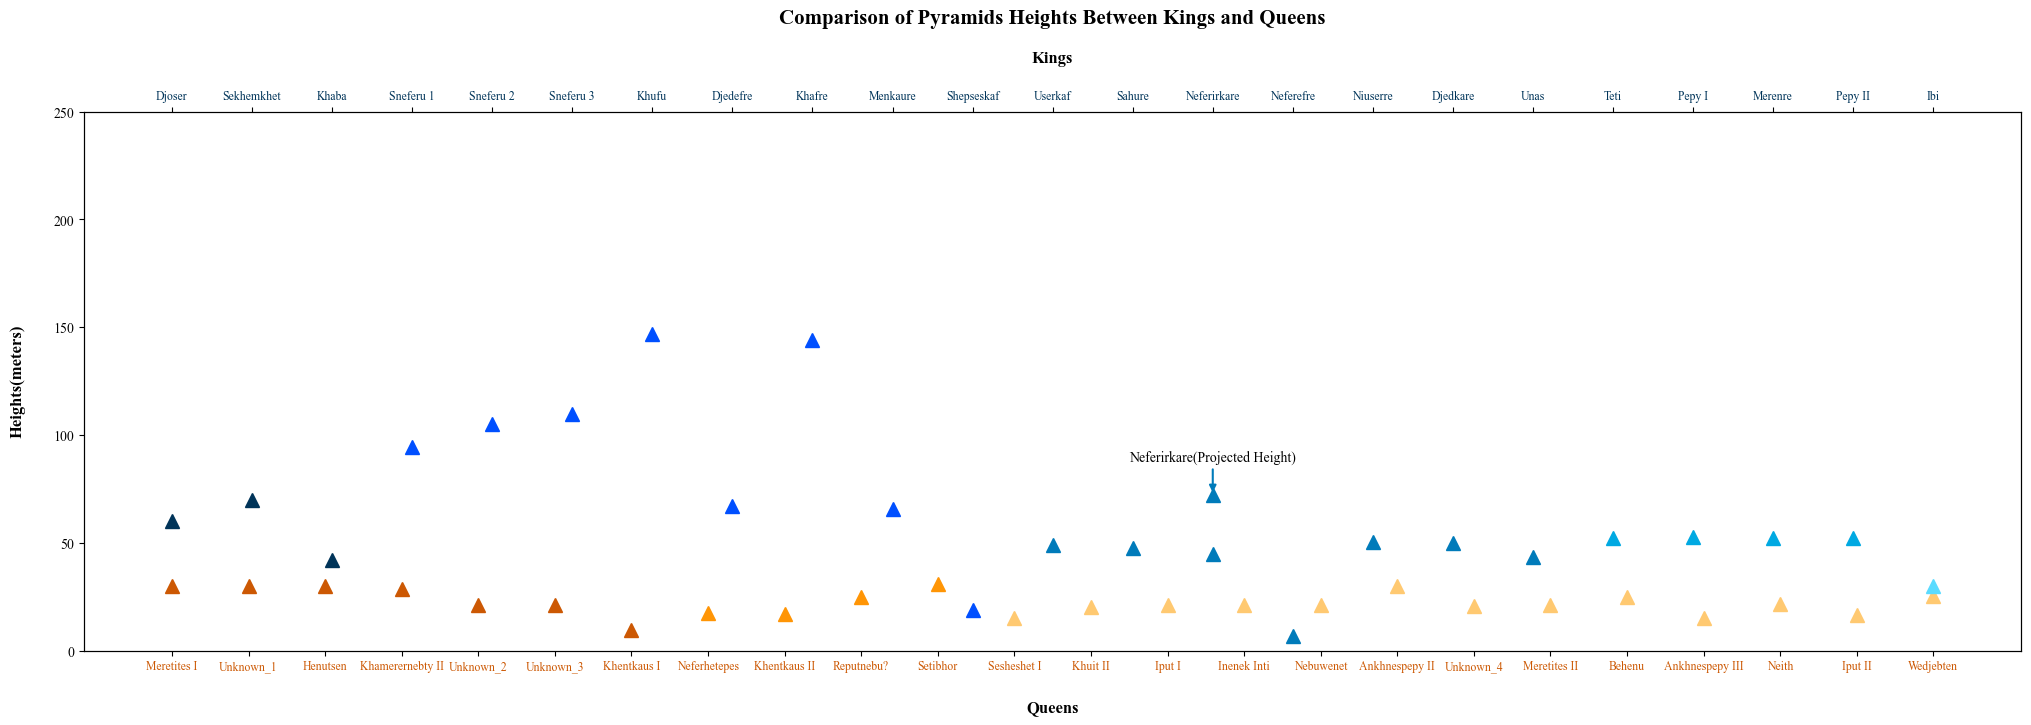

,height,royal_status,pyramid_complex,length_of_reign_x,dynasty,length_of_reign_y
0,59.90,King,Djoser,19.000000,3.0,19
1,70.00,King,Sekhemkhet,8.000000,3.0,8
2,42.00,King,Khaba,4.000000,3.0,4
3,94.50,King,Sneferu 1,24.000000,4.0,24
4,105.07,King,Sneferu 2,24.000000,4.0,24
5,109.54,King,Sneferu 3,NaN,4.0,0
6,146.59,King,Khufu,23.000000,4.0,23
7,67.00,King,Djedefre,8.000000,4.0,8
8,143.80,King,Khafre,26.000000,4.0,26
9,65.55,King,Menkaure,18.000000,4.0,18


In [26]:
complex_heights_kings = df[['height', 'royal_status', 'pyramid_complex', 'length_of_reign','dynasty']][(df['royal_status'] == 'King') & (pd.notnull(df['height']))].reset_index(drop=True)
complex_reign_length = complex_heights_kings.groupby('pyramid_complex', sort=False, as_index=False)['length_of_reign'].sum()
complex_reign_length['length_of_reign'] = complex_reign_length['length_of_reign'].astype(int)
merged_kings_reign_df = pd.merge(complex_heights_kings, complex_reign_length, on=['pyramid_complex'], how='left')
merged_kings_reign_df.at[13, 'height'] = '44.98'
merged_kings_reign_df['height'] = pd.to_numeric(merged_kings_reign_df['height'])

complex_heights_queens = df[['height', 'royal_status', 'pyramid_complex', 'dynasty', 'pyramid_owner']][(df['royal_status'] == 'Queen') & (pd.notnull(df['height']))][['height', 'pyramid_complex', 'dynasty','royal_status', 'pyramid_owner']].reset_index(drop=True)
complex_heights_queens.at[6, 'height'] = 9.365
complex_heights_queens.at[22, 'height'] = 16.5
complex_heights_queens.at[1,'pyramid_owner'] = 'Unknown_1'
complex_heights_queens.at[4,'pyramid_owner'] = 'Unknown_2'
complex_heights_queens.at[5,'pyramid_owner'] = 'Unknown_3'
complex_heights_queens.at[17,'pyramid_owner'] = 'Unknown_4'
complex_heights_queens['height'] = pd.to_numeric(complex_heights_queens['height'])
complex_heights_queens


fig, ax1 = plt.subplots(figsize=(25, 7))
plt.rcParams['font.family'] = 'Times New Roman'
ax1.set_xticks(range(len(complex_heights_queens)))
ax1.set_xticklabels(complex_heights_queens['pyramid_owner'], fontsize=8.5, rotation=0,color='#cc5803')
ax1.set_xlabel('Queens',fontweight='bold',fontsize=12,labelpad=20)
ax1.set_ylabel('Heights(meters)',labelpad=20,fontweight='bold',fontsize=12)
ax1.set_ylim(0, 250)
ax1.tick_params(axis='x', rotation=0)
queens_colors= ['#cc5803', '#cc5803', '#cc5803','#cc5803','#cc5803', '#cc5803', '#cc5803', '#ff9505','#ff9505',  '#ff9505', '#ff9505','#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971' ]
for i, row in complex_heights_queens.iterrows():
    ax1.plot(i, row['height'], '^', color=queens_colors[i % len(queens_colors)], markersize=10)
    
ax2 = ax1.twiny()
ax2.set_xticks(range(len(merged_kings_reign_df)))
ax2.set_xticklabels(merged_kings_reign_df['pyramid_complex'], fontsize=8.5, rotation=0, color='#003459')
ax2.set_xlabel('Kings',labelpad=20,fontweight='bold',fontsize=12)
ax2.tick_params(axis='x', rotation=0)
ax2.set_title('Comparison of Pyramids Heights Between Kings and Queens',pad=20, fontweight='bold',fontsize=15)
kings_colors= ['#003459', '#003459', '#003459','#004fff', '#004fff', '#004fff', '#004fff', '#004fff','#004fff',  '#004fff', '#004fff','#007bba', '#007bba', '#007bba', '#007bba', '#007bba','#007bba', '#007bba', '#00a9e2', '#00a9e2', '#00a9e2', '#00a9e2', '#5adbff' ]
for i, row in merged_kings_reign_df.iterrows():
    ax2.plot(i, row['height'], '^', color=kings_colors[i % len(kings_colors)], markersize=10)
neferirkare_index = merged_kings_reign_df[merged_kings_reign_df['pyramid_complex'] == 'Neferirkare'].index[0]
ax2.plot(neferirkare_index, 72, '^', color='#007bba', markersize=10)  
ax2.annotate(
    'Neferirkare(Projected Height)',
    xy=(neferirkare_index, 72),
    xytext=(0, 25),
    textcoords='offset points',
    arrowprops=dict(facecolor='#007bba', edgecolor='#007bba', arrowstyle='-|>', lw=1.5),
    ha='center', fontsize=10
)


# legend=ax1.legend(loc='upper right',title='Royal Status(Dynasty)')
# legend.get_frame().set_facecolor('none')
# legend.get_frame().set_edgecolor('none')
# plt.setp(legend.get_title(), fontweight='bold', fontsize=10)

plt.show()
merged_kings_reign_df

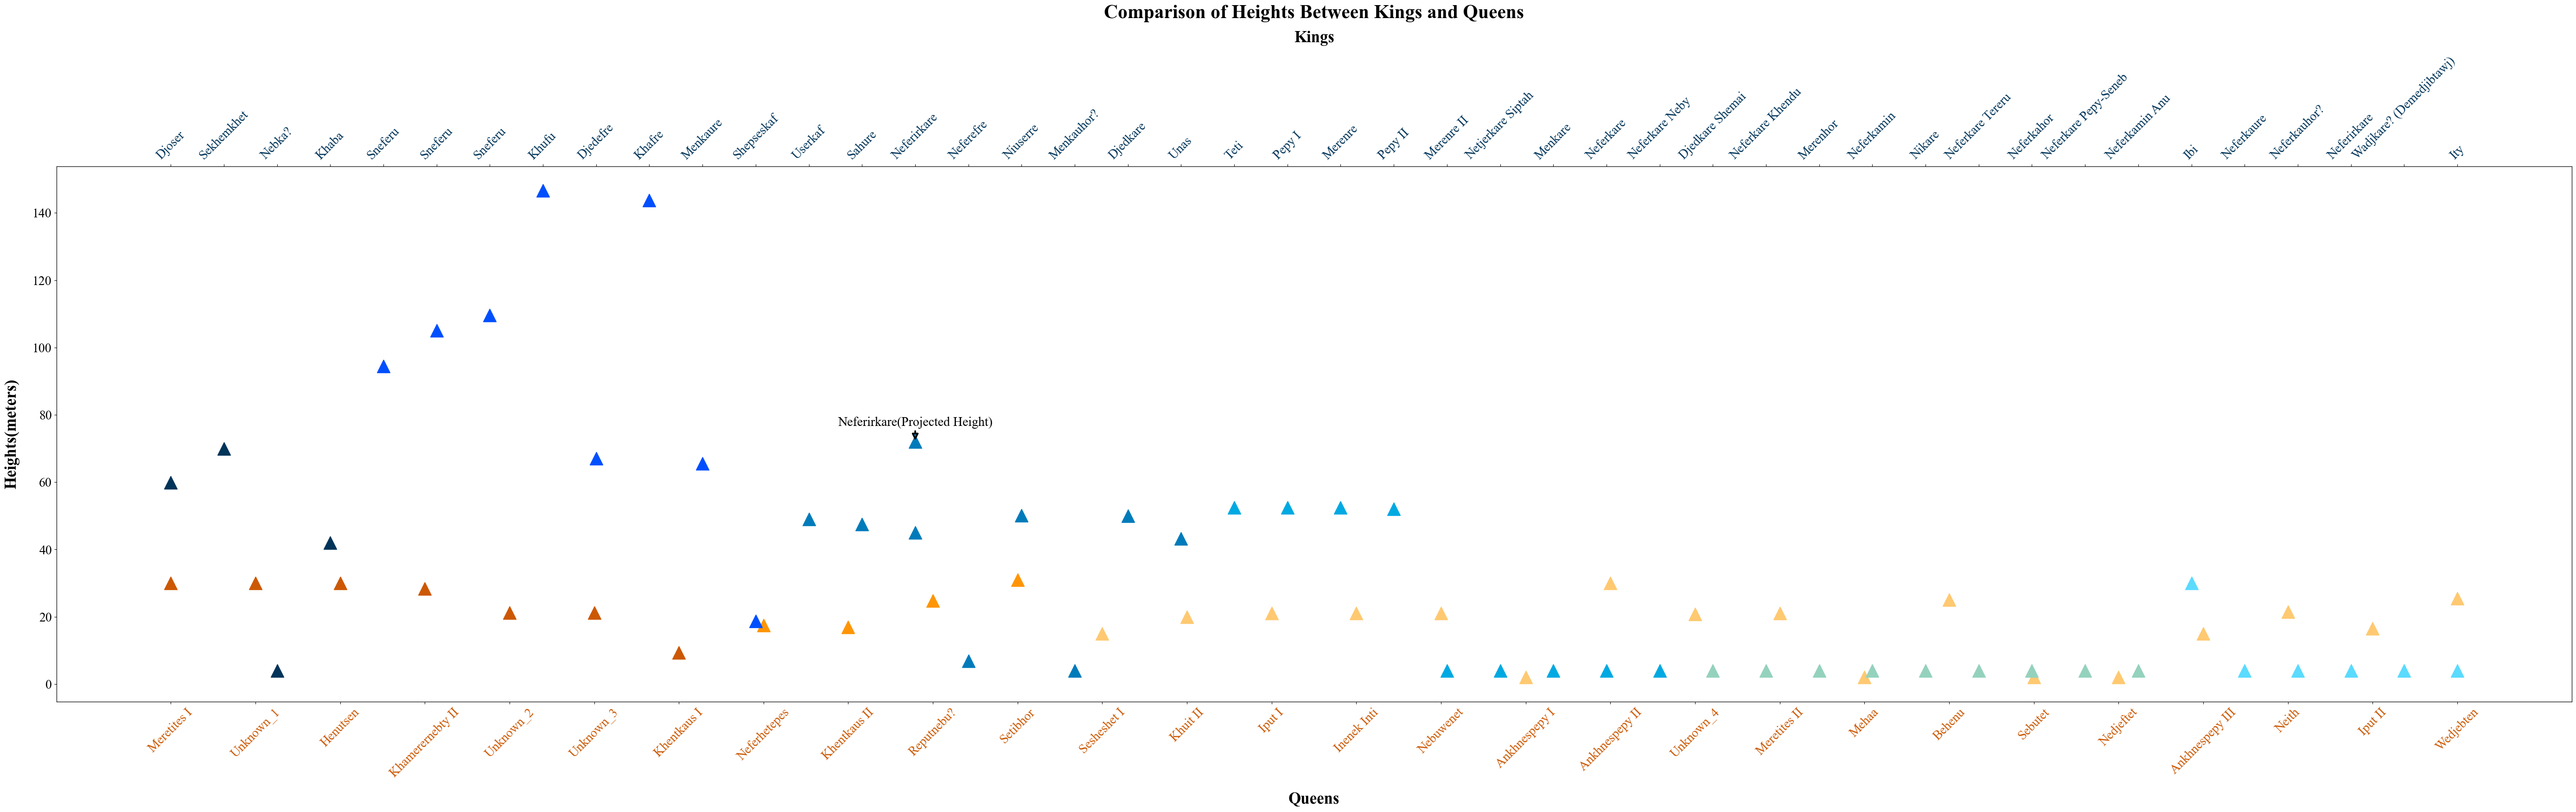

In [91]:
all_heights_kings = df[['height', 'royal_status', 'pyramid_owner','dynasty','pyramid_complex']][(df['royal_status'] == 'King')].reset_index(drop=True)
for i in range(len(all_heights_kings)):
    if pd.isna(all_heights_kings.at[i,'height']):
        all_heights_kings.at[i,'height']=4
all_heights_kings.at[14, 'height'] = '44.98'
all_heights_kings['height'] = pd.to_numeric(all_heights_kings['height'])
all_heights_kings

all_heights_queens=df[['height', 'royal_status', 'pyramid_complex', 'dynasty', 'pyramid_owner']][(df['royal_status'] == 'Queen')][['height', 'pyramid_complex', 'dynasty','royal_status', 'pyramid_owner']].reset_index(drop=True)
for i in range(len(all_heights_queens)):
    if pd.isna(all_heights_queens.at[i,'height']):
        all_heights_queens.at[i,'height']=2
all_heights_queens.at[6, 'height'] = 9.365
all_heights_queens.at[26, 'height'] = 16.5
all_heights_queens.at[1,'pyramid_owner'] = 'Unknown_1'
all_heights_queens.at[4,'pyramid_owner'] = 'Unknown_2'
all_heights_queens.at[5,'pyramid_owner'] = 'Unknown_3'
all_heights_queens.at[18,'pyramid_owner'] = 'Unknown_4'
all_heights_queens['height'] = pd.to_numeric(all_heights_queens['height'])
all_heights_queens


fig, ax1 = plt.subplots(figsize=(70, 15))
plt.rcParams['font.family'] = 'Times New Roman'
ax1.set_xticks(range(len(all_heights_queens)))
ax1.set_xticklabels(all_heights_queens['pyramid_owner'], fontsize=20, rotation=45,color='#cc5803')
ax1.set_xlabel('Queens',fontweight='bold',fontsize=25,labelpad=20)
ax1.set_ylabel('Heights(meters)',labelpad=20,fontweight='bold',fontsize=25)
ax1.tick_params(axis='y', labelsize=20) 
queens_colors= ['#cc5803', '#cc5803', '#cc5803','#cc5803','#cc5803', '#cc5803', '#cc5803', '#ff9505','#ff9505',  '#ff9505', '#ff9505','#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971' ]
for i, row in all_heights_queens.iterrows():
    ax1.plot(i, row['height'], '^', color=queens_colors[i % len(queens_colors)], markersize=20)
    
ax2 = ax1.twiny()
ax2.set_xticks(range(len(all_heights_kings)))
ax2.set_xticklabels(all_heights_kings['pyramid_owner'], fontsize=20, rotation=45, color='#003459')
ax2.set_xlabel('Kings',labelpad=20,fontweight='bold',fontsize=25)
ax2.set_title('Comparison of Pyramids Heights Between Kings and Queens',pad=20, fontweight='bold',fontsize=15)
kings_colors= ['#003459', '#003459', '#003459','#003459','#004fff', '#004fff', '#004fff', '#004fff', '#004fff','#004fff',  '#004fff', '#004fff','#007bba', '#007bba', '#007bba', '#007bba','#007bba', '#007bba','#007bba', '#007bba', '#00a9e2', '#00a9e2', '#00a9e2', '#00a9e2', '#00a9e2','#00a9e2','#00a9e2','#00a9e2','#00a9e2','#94d2bd','#94d2bd','#94d2bd','#94d2bd','#94d2bd','#94d2bd','#94d2bd','#94d2bd','#94d2bd','#5adbff','#5adbff' ,'#5adbff' ,'#5adbff' ,'#5adbff' ,'#5adbff','#5adbff'  ]
for i, row in all_heights_kings.iterrows():
    ax2.plot(i, row['height'], '^', color=kings_colors[i % len(kings_colors)], markersize=20)
neferirkare_index = all_heights_kings[all_heights_kings['pyramid_complex'] == 'Neferirkare'].index[0]
ax2.plot(neferirkare_index, 72, '^', color='#007bba', markersize=20)  
ax2.annotate(
    'Neferirkare(Projected Height)',
    xy=(neferirkare_index, 72),
    xytext=(0, 25),
    textcoords='offset points',
    arrowprops=dict(facecolor='#007bba', edgecolor='black', arrowstyle='-|>', lw=2.5),
    ha='center', fontsize=20
)
ax2.set_title('Comparison of Heights Between Kings and Queens',pad=20, fontweight='bold',fontsize=30)
plt.show()


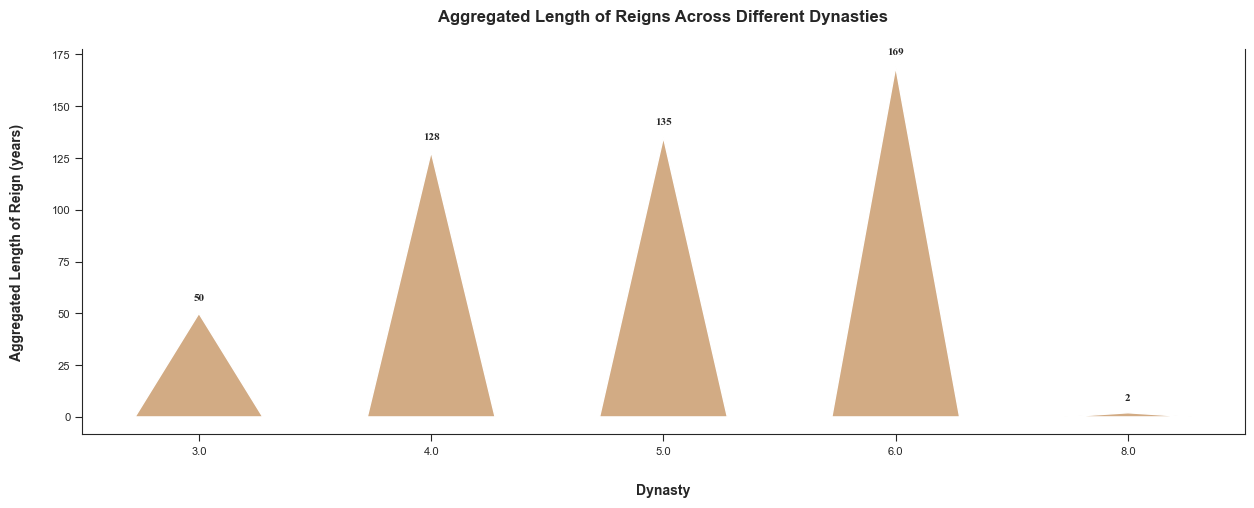

In [31]:
dynasties_length_of_reign = complexes.groupby('dynasty')['length_of_reign'].sum().reset_index()
dynasties_length_of_reign['length_of_reign']=dynasties_length_of_reign['length_of_reign'].astype(int)
fig, ax = plt.subplots(figsize=(15, 5))
sns.set_style(style='ticks')
plt.tick_params(axis='both', which='major', length=5) 
ax.tick_params(axis='both', labelsize=8) 
plt.rcParams['font.family'] = 'Times New Roman'
for i, (category, value) in enumerate(zip(dynasties_length_of_reign['dynasty'].to_list(), dynasties_length_of_reign['length_of_reign'].to_list())):
    ax.fill([i-0.275, i, i+0.275], [0, value, 0], color='#d2ab84', alpha=1, edgecolor='white', linewidth=1.)
    ax.text(i, value + 5, f'{value}', ha='center', va='bottom', fontsize=8, fontweight='bold')
ax.set_xticks(range(len(dynasties_length_of_reign['dynasty'].to_list())))
ax.set_xticklabels(dynasties_length_of_reign['dynasty'].to_list())
plt.title('Aggregated Length of Reigns Across Different Dynasties',fontweight='bold',pad=20, fontsize=12)
plt.xlabel('Dynasty',fontweight='bold',labelpad=20, fontsize=10)
plt.ylabel('Aggregated Length of Reign (years)', fontweight='bold',labelpad=20, fontsize=10)
ax.spines['top'].set_visible(False)
plt.show()

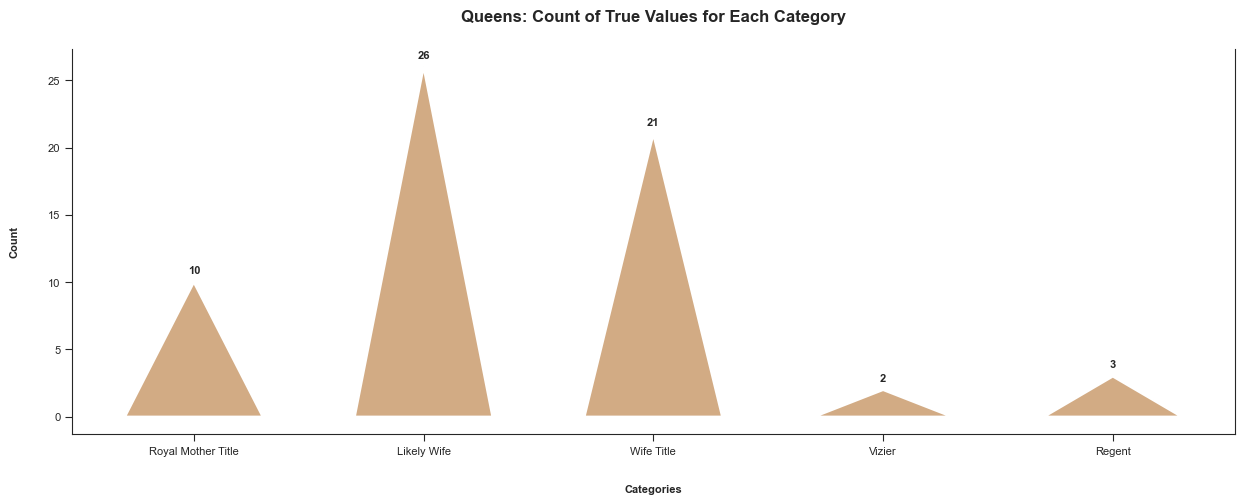

In [33]:

queens_status=df[['royal_mother_title','likely_wife','wife_title','vizier','regent','royal_status']][(df['royal_status'] == 'Queen')].drop(columns=['royal_status']).reset_index(drop=True)
queens_status = queens_status.map(lambda x: str(x))
queens_status_true = queens_status.apply(lambda x: x.value_counts()).transpose()['True'].reset_index()
queens_status_true['index']

plt.figure(figsize=(15, 5))
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_style(style='ticks')
ax = plt.gca()

for i, row in queens_status_true.iterrows():
    true_count = row['True'] if 'True' in queens_status_true.columns else 0

    ax.fill([i - 0.3, i, i + 0.3], [0, true_count, 0], color='#d2ab84',alpha=1, edgecolor='white', linewidth=1.7, label='True' if i == 0 else "")
    ax.text(i, true_count + 0.5, f'{true_count}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    

ax.set_xticks([i - 0 for i in range(len(queens_status_true.index))])
ax.set_xticklabels(['Royal Mother Title', 'Likely Wife', 'Wife Title', 'Vizier', 'Regent'])
plt.tick_params(axis='both', which='major', length=5) 
ax.tick_params(axis='both', labelsize=8) 

plt.xlabel('Categories', fontsize=8,fontweight='bold',labelpad=20)
plt.ylabel('Count', fontsize=8,fontweight='bold',labelpad=20)
plt.title('Queens: Count of True Values for Each Category', fontsize=12,fontweight='bold',pad=20)
plt.xticks(rotation=0)
ax.spines['top'].set_visible(False)

plt.show()


In [92]:
queens_df=df[['pyramid_owner','pyramid_complex','royal_status','height','dynasty','relationship_to_king','royal_mother_title','likely_wife','wife_title','vizier','regent']][(df['royal_status'] == 'Queen')].reset_index(drop=True)
queens_df.at[6, 'height'] = 9.365
queens_df.at[26, 'height'] = 16.5
queens_df.at[16, 'height'] = 5
queens_df.at[20, 'height'] = 5
queens_df.at[22, 'height'] = 5
queens_df.at[23, 'height'] = 5
queens_df.at[1,'pyramid_owner'] = 'Unknown_1'
queens_df.at[4,'pyramid_owner'] = 'Unknown_2'
queens_df.at[5,'pyramid_owner'] = 'Unknown_3'
queens_df.at[18,'pyramid_owner'] = 'Unknown_4'
queens_df['height'] = pd.to_numeric(queens_df['height'])

pattern= r'(Mother and Queen Regent for|Wife of|Wife to|Mother of|Mother to|Sister of|Royal Mother|Daughter of|Likely wife but) ([^,?()]+)'
i=0
for index, row in queens_df.iterrows():
    if re.search(pattern,row['relationship_to_king']):
        i+=1
        text=row['relationship_to_king']
        matches = re.findall(pattern, text)
        order = [(match[0], match[1].strip()) for match in matches]
        queens_df.at[index,'relationship_to_king']=order

def wife_to(relations):
    relation_names = ""
    king_wife = [relation[1] for relation in relations if (relation[0] == 'Wife of' or relation[0] == 'Wife to')]
    if len(king_wife)>1:
            relation_names = f"{king_wife[0]} and {king_wife[1]}"

    else:
            relation_names =  f"{', '.join(king_wife)}"

    return relation_names 
def daughter_to(relations):
    relation_names = ""

    king_daughter=[relation[1] for relation in relations if (relation[0] == 'Daughter of' or relation[0] == 'Daughter to')]
    if king_daughter:
        relation_names = f" {', '.join(king_daughter)}"

    return relation_names 
def mother_to(relations):
    relation_names = ""

    king_mother=[relation[1] for relation in relations if (relation[0] == 'Mother of' or relation[0] == 'Mother to')]
    king_mother_regent=[relation[1] for relation in relations if (relation[0] == 'Mother and Queen Regent for')]
    if king_mother:
        relation_names = f" {', '.join(king_mother)}"
    if king_mother_regent:
        if relation_names != "":
            relation_names = relation_names + " and " + f"{', '.join(king_mother_regent)}"
        else:
            relation_names = f" {', '.join(king_mother_regent)}"

    return relation_names 
def royal_mother_to(relations):
    relation_names = ""

    king_royal_mother=[relation[1] for relation in relations if (relation[0] == 'Royal Mother')]
    royal_mother = f"Royal Mother to {', '.join(king_royal_mother)}"
    pattern = r'(likely of) ([^,())]+)'
    matches = re.findall(pattern, royal_mother)
    if king_royal_mother:
        relation_names = f" {matches[0][1]}"

    return relation_names 
def sister_to(relations):
    relation_names = ""

    king_sister=[relation[1] for relation in relations if (relation[0] == 'Sister of' or relation[0] == 'Sister to to')]
    if king_sister:
        relation_names = f" {', '.join(king_sister)}"

    return relation_names 
def queen_regent_to(relations):
    relation_names = ""

    king_mother_regent=[relation[1] for relation in relations if (relation[0] == 'Mother and Queen Regent for')]
    if king_mother_regent:
        relation_names = f" {', '.join(king_mother_regent)}"

    return relation_names 

# def transform_rows(relations):
#     relation_names=""
#     king_wife = [relation[1] for relation in relations if (relation[0] == 'Wife of' or relation[0] == 'Wife to')]
#     king_liekly_wife=[relation[1] for relation in relations if (relation[0] == 'Likely wife but')]
#     king_daughter=[relation[1] for relation in relations if (relation[0] == 'Daughter of' or relation[0] == 'Daughter to')]
#     king_mother=[relation[1] for relation in relations if (relation[0] == 'Mother of' or relation[0] == 'Mother to')]
#     king_royal_mother=[relation[1] for relation in relations if (relation[0] == 'Royal Mother')]
#     king_sister=[relation[1] for relation in relations if (relation[0] == 'Sister of' or relation[0] == 'Sister to to')]
#     king_mother_regent=[relation[1] for relation in relations if (relation[0] == 'Mother and Queen Regent for')]

#     if king_wife:
#         if len(king_wife)>1:
#             relation_names = f"Wife to {king_wife[0]} and {king_wife[1]} " 
#         else: 
#             relation_names =  f"Wife to {', '.join(king_wife)}"
#     if king_royal_mother:
#         royal_mother = f"Royal Mother to {', '.join(king_royal_mother)}"
#         pattern = r'(likely of) ([^,())]+)'
#         matches = re.findall(pattern, royal_mother)
#         if  relation_names != "":
#             relation_names = relation_names +" ; " + f"Royal Mother to {matches[0][1]}"
    #     else:
    #         relation_names = f"Royal Mother to {matches[0][1]}"
    # if king_mother:
    #     if  relation_names != "":
    #         relation_names = relation_names +" ; " + f"Mother to {', '.join(king_mother)}"
    #     else:
    #         relation_names = f"Mother to {', '.join(king_mother)}"
    # if king_daughter:
    #     if relation_names != "":
    #         relation_names = relation_names + " ; " + f" Daughter to {', '.join(king_daughter)}"
    #     else:
    #         relation_names = f" Daughter to {', '.join(king_daughter)}"
    # if king_sister:
    #     if relation_names != "":
    #         relation_names = relation_names + " ; " + f"Sister to {', '.join(king_sister)}"
    #     else:
    #         relation_names = "Sister to {', '.join(king_sister)}"
    # if king_mother_regent:
    #     if relation_names != "":
    #         relation_names = relation_names + " ; " + f"Mother to {', '.join(king_mother_regent)}"
    #         relation_names = relation_names + " ; " + f"Queen Regent to {', '.join(king_mother_regent)}"
    #     else:
    #         relation_names =  f"Mother to {', '.join(king_mother_regent)}"
    #         relation_names = relation_names + " ; " + f"Queen Regent to {', '.join(king_mother_regent)}"
    # return relation_names

queens_df['wife_to'] = queens_df['relationship_to_king'].apply(wife_to)
queens_df['daughter_to'] = queens_df['relationship_to_king'].apply(daughter_to)
queens_df['mother_to'] = queens_df['relationship_to_king'].apply(mother_to)
queens_df['royal_mother_to'] = queens_df['relationship_to_king'].apply(royal_mother_to)
queens_df['sister_to'] = queens_df['relationship_to_king'].apply(sister_to)
queens_df['queen_regent_to'] = queens_df['relationship_to_king'].apply(queen_regent_to)
queens_df.drop(columns=['relationship_to_king'], inplace=True)
# queens_df['relationship_to_king'] = queens_df['relationship_to_king'].apply(transform_rows)

queens_df.replace('', pd.NA, inplace=True)
queens_df.head()

,pyramid_owner,pyramid_complex,royal_status,height,dynasty,royal_mother_title,likely_wife,wife_title,vizier,regent,wife_to,daughter_to,mother_to,royal_mother_to,sister_to,queen_regent_to
0,Meretites I,Khufu,Queen,30.00,4.0,False,True,True,False,False,Sneferu and Khufu,<NA>,<NA>,<NA>,<NA>,<NA>
1,Unknown_1,Khufu,Queen,30.00,4.0,False,True,False,False,False,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,Henutsen,Khufu,Queen,30.00,4.0,False,True,True,False,False,Khufu,<NA>,<NA>,<NA>,<NA>,<NA>
3,Khamerernebty II,Menkaure,Queen,28.40,4.0,False,True,True,False,False,Menkaure,Khafre,<NA>,<NA>,<NA>,<NA>
4,Unknown_2,Menkaure,Queen,21.18,4.0,False,True,False,False,False,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


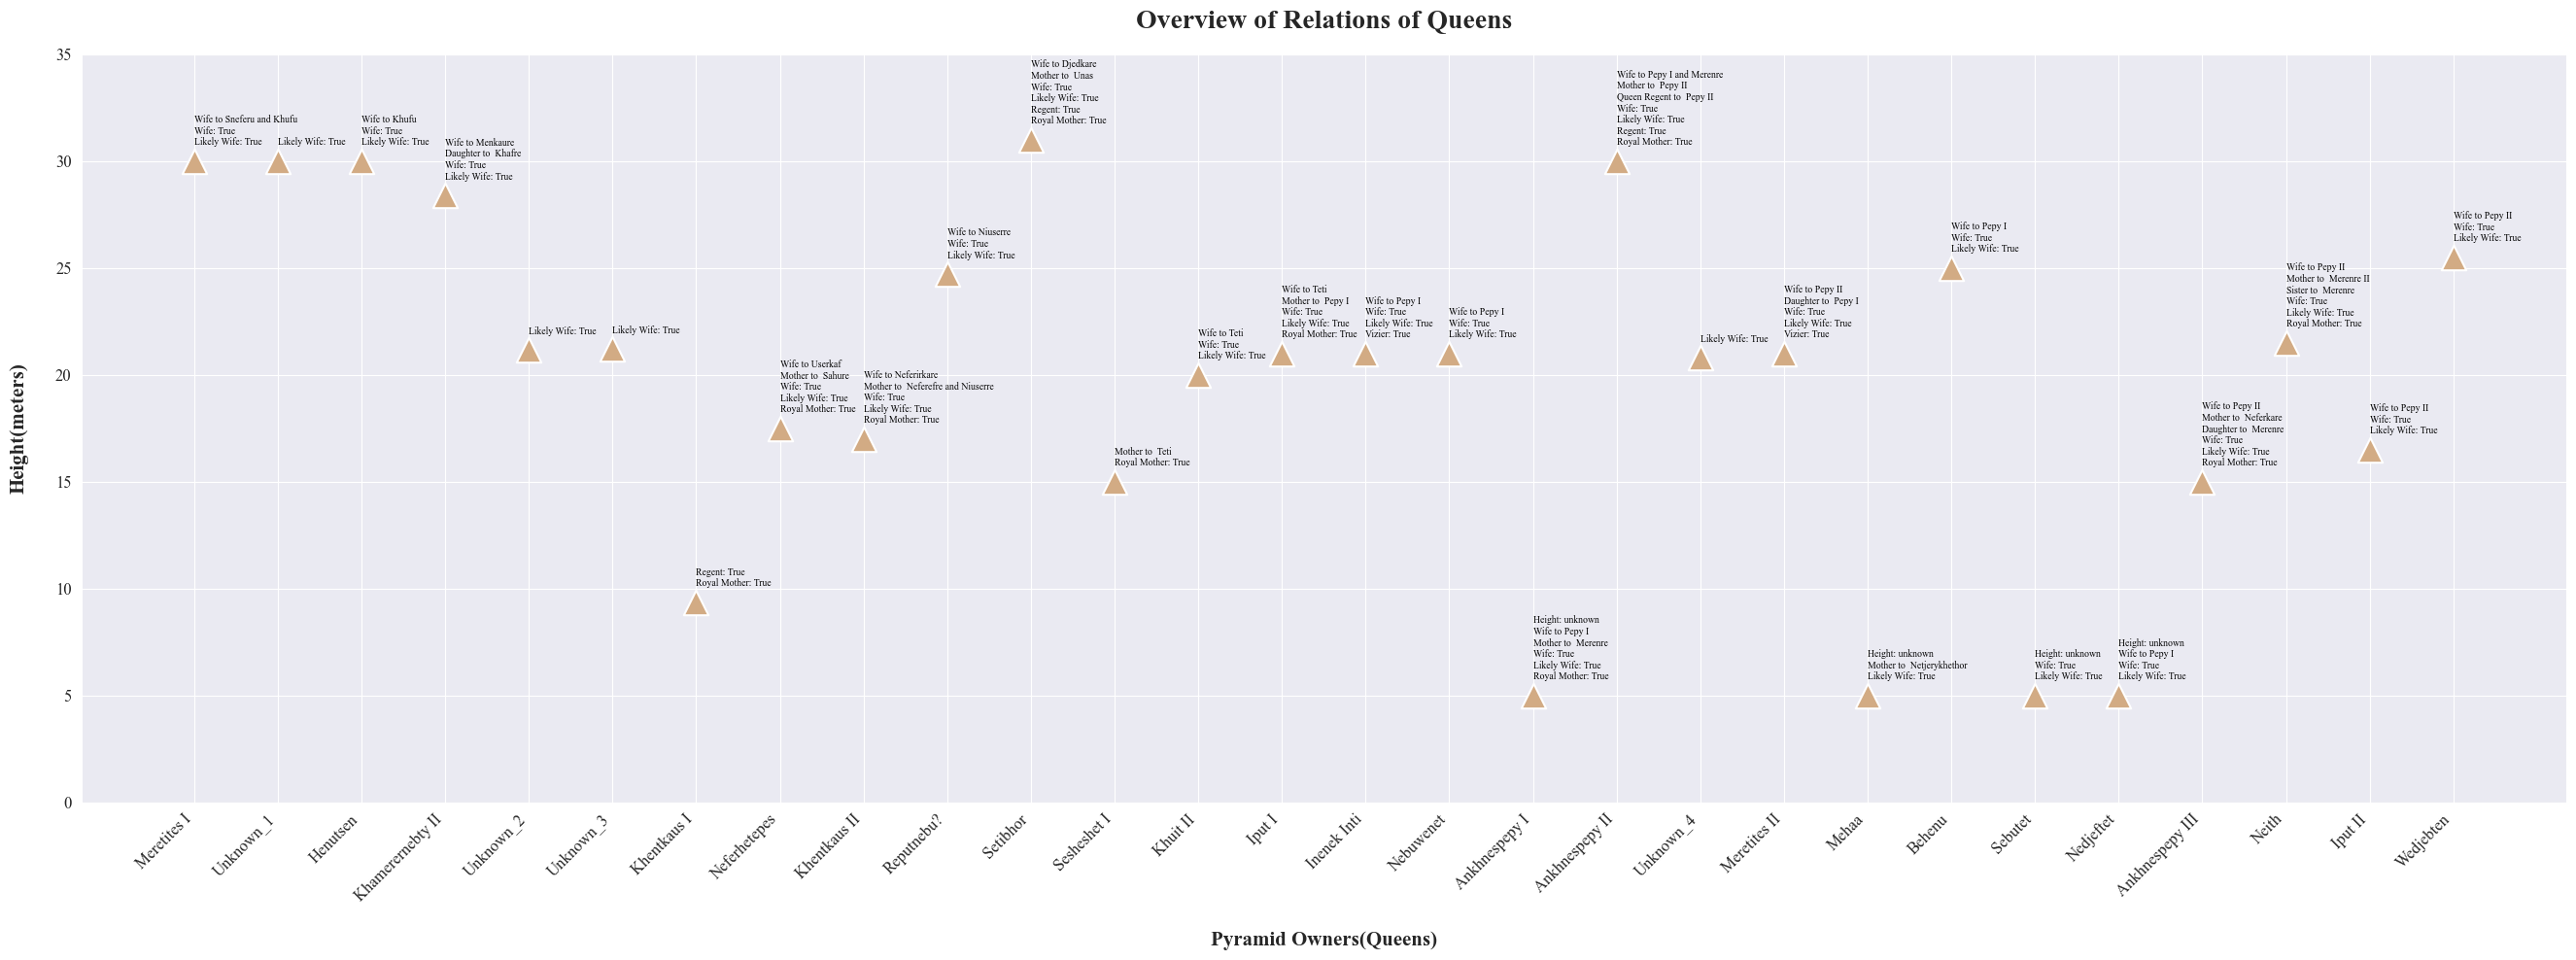

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np

sns.set_style(style='darkgrid')
plt.rcParams['font.family'] = 'Times New Roman'
queens_df['pyramid_owner_num'] = np.linspace(0.1, 3, len(queens_df))

fig, ax = plt.subplots(figsize=(33, 10))


scatter = ax.scatter(queens_df['pyramid_owner_num'] , queens_df['height'], s=335, alpha=1, edgecolors='white', linewidth=1.5, marker='^', color='#d2ab84')

for _, row in queens_df.iterrows():
    details = [
        f"Height: unknown" if row['height']==5.0 else "",
        f"Wife to {row['wife_to']}" if pd.notna(row['wife_to']) else "",
        f"Royal Mother to {row['royal_mother_to']}" if pd.notna(row['royal_mother_to']) else "",
        f"Mother to {row['mother_to']}" if pd.notna(row['mother_to']) else "",
        f"Sister to {row['sister_to']}" if pd.notna(row['sister_to']) else "",
        f"Queen Regent to {row['queen_regent_to']}" if pd.notna(row['queen_regent_to']) else "",
        f"Daughter to {row['daughter_to']}" if pd.notna(row['daughter_to']) else "",
        f"Wife: {row['wife_title']}" if (row['wife_title']==True) else "",
        f"Likely Wife: {row['likely_wife']}" if (row['likely_wife']==True) else "",
        f"Vizier: {row['vizier']}" if (row['vizier']==True) else "",
        f"Regent: {row['regent']}" if (row['regent']==True) else "",
        f"Royal Mother: {row['royal_mother_title']}" if (row['royal_mother_title']==True) else ""
       # f"Wife Title: {row['wife_title']}" if (pd.notna(row['wife_title']) and pd.notna(row['wife_title']==True) ) else "",
    ]
    details = "\n".join(filter(None, details))  # Join non-empty strings with a newline

    ax.text(row['pyramid_owner_num'], row['height'] + 0.65, details,
            fontproperties=FontProperties(family='Times New Roman', size=7), color='black', ha='left', va='bottom')


ax.set_ylim(0, 35)
ax.tick_params(axis='y', labelsize=12) 
ax.set_xticks(queens_df['pyramid_owner_num'])
ax.set_xticklabels(labels=queens_df['pyramid_owner'],rotation=45, ha='right', fontsize=12)  # Use the original pyramid_owner values as labels
ax.grid(True, axis='y')

plt.title('Overview of Relations of Queens',fontweight='bold',pad=20, fontsize=20)
plt.xlabel('Pyramid Owners(Queens)',fontweight='bold',labelpad=20, fontsize=15)
plt.ylabel('Height(meters)', fontweight='bold',labelpad=20, fontsize=15)

plt.show()


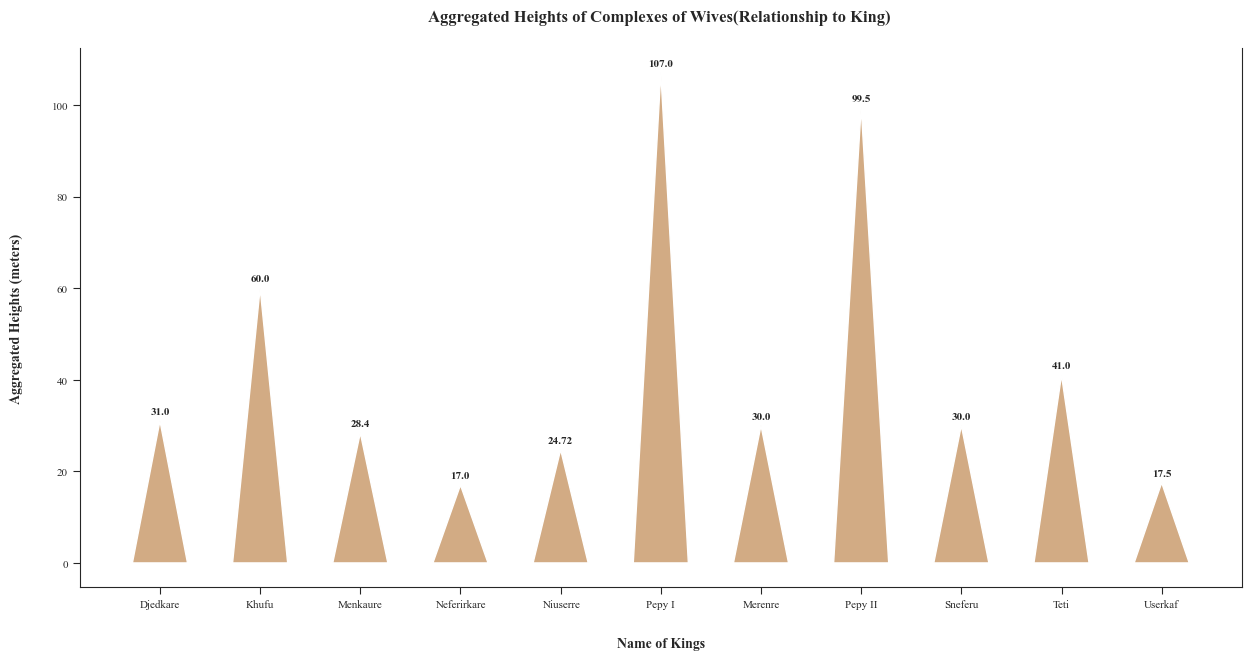

In [98]:
wifes_total_heights = queens_df.groupby('wife_to').agg(
    count=('wife_to', 'size'),
    total_height=('height', 'sum')
).reset_index()
wifes_total_heights.at[6,'wife_to']='Merenre'
wifes_total_heights.at[5,'count']=6
wifes_total_heights.at[5,'total_height']=107
wifes_total_heights.at[8,'wife_to']='Sneferu'
wifes_total_heights.at[1,'count']=2
wifes_total_heights.at[1,'total_height']=60
fig, ax = plt.subplots(figsize=(15, 7))
sns.set_style(style='ticks')
plt.tick_params(axis='both', which='major', length=5) 
ax.tick_params(axis='both', labelsize=8) 
plt.rcParams['font.family'] = 'Times New Roman'
for i, (category, value) in enumerate(zip(wifes_total_heights['wife_to'].to_list(), wifes_total_heights['total_height'].to_list())):
    ax.fill([i-0.275, i, i+0.275], [0, value, 0], color='#d2ab84', alpha=1, edgecolor='white', linewidth=1.)
    ax.text(i, value + 1, f'{value}', ha='center', va='bottom', fontsize=8, fontweight='bold')
ax.set_xticks(range(len(wifes_total_heights['wife_to'].to_list())))
ax.set_xticklabels(wifes_total_heights['wife_to'].to_list())
plt.title('Aggregated Heights of Complexes of Wives(Relationship to King) ',fontweight='bold',pad=20, fontsize=12)
plt.xlabel('Name of Kings',fontweight='bold',labelpad=20, fontsize=10)
plt.ylabel('Aggregated Heights (meters)', fontweight='bold',labelpad=20, fontsize=10)
ax.spines['top'].set_visible(False)
plt.show()

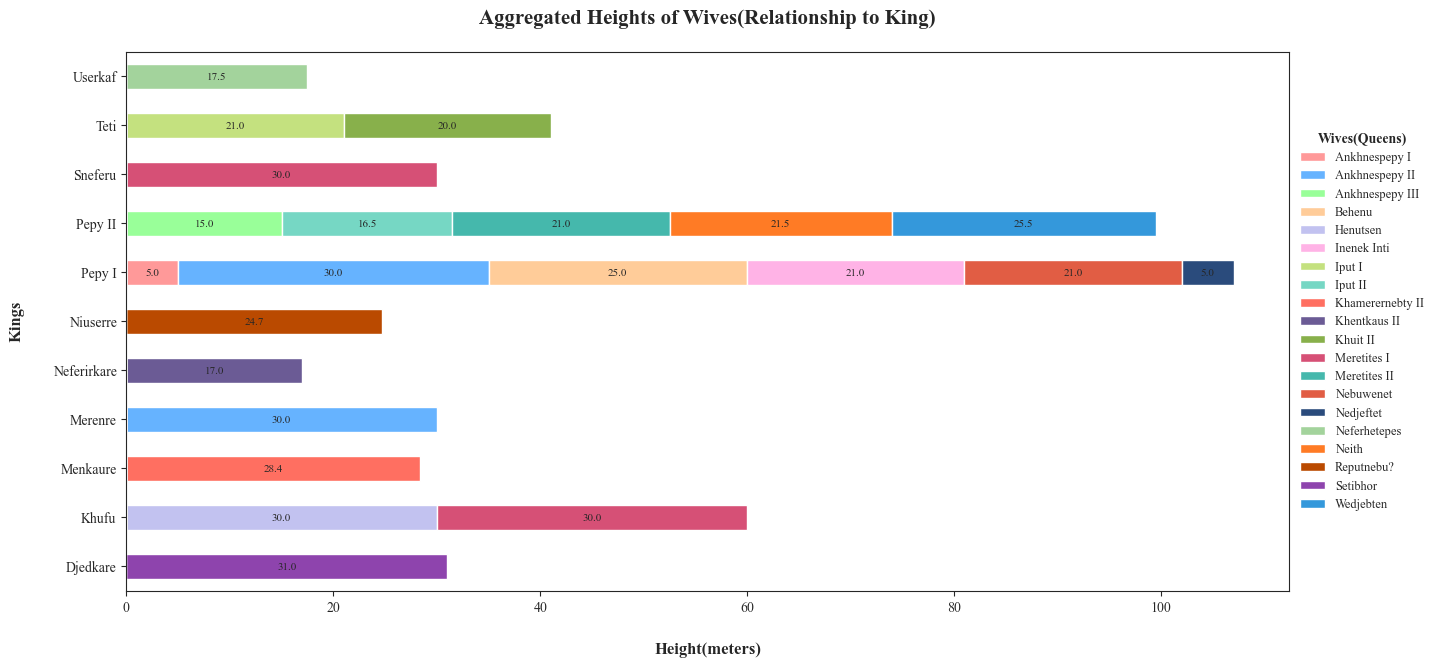

In [100]:
wifes_heights = queens_df[['wife_to','height','pyramid_owner']][pd.notna(queens_df['wife_to'])].reset_index(drop=True)
wifes_heights.at[0,'wife_to']='Sneferu'
wifes_heights.at[12,'wife_to']='Merenre'
new_pepy_row={'wife_to':'Pepy I', 'height':30, 'pyramid_owner':'Ankhnespepy II'}
new_khufu_row={'wife_to':'Khufu', 'height':30, 'pyramid_owner':'Meretites I'}
wifes_heights.loc[len(wifes_heights)] = new_pepy_row
wifes_heights.loc[len(wifes_heights)] = new_khufu_row
wifes_heights

pivot_df = wifes_heights.pivot_table(index='wife_to', columns='pyramid_owner', values='height', aggfunc='sum', fill_value=0)


fig, ax = plt.subplots(figsize=(15, 7))
plt.rcParams['font.family'] = 'Times New Roman'
pivot_df = wifes_heights.pivot_table(index='wife_to', columns='pyramid_owner', values='height', aggfunc='sum', fill_value=0)


custom_colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6',
               '#c4e17f', '#76d7c4', '#ff6f61', '#6b5b95', '#88b04b', '#d65076',
               '#45b8ac', '#e15d44', '#2a4b7c', '#a3d39c', '#ff7b25', '#ba4a00',
               '#8e44ad', '#3498db', '#e74c3c']


pivot_df.plot(kind='barh', stacked=True, ax=ax, color=custom_colors)

for bars in ax.containers:
    ax.bar_label(bars, label_type='center', fmt='%.1f', fontsize=8)
for text in ax.texts:
        if text.get_text() == '0.0':
            text.set_visible(False)

ax.set_xlabel('Height(meters)',labelpad=20,fontsize=12,fontweight='bold')
ax.set_ylabel('Kings',labelpad=20,fontweight='bold',fontsize=12)
ax.set_title('Aggregated Heights of Wives(Relationship to King)',pad=20,fontsize=15,fontweight='bold')

legend = ax.legend(
        title='Wives(Queens)', bbox_to_anchor=(1, 0.5), fontsize=9,loc="center left"
    )
legend.get_frame().set_facecolor("white")
legend.get_frame().set_edgecolor("white")
plt.setp(legend.get_title(), fontweight="bold", fontsize=10)

plt.show()


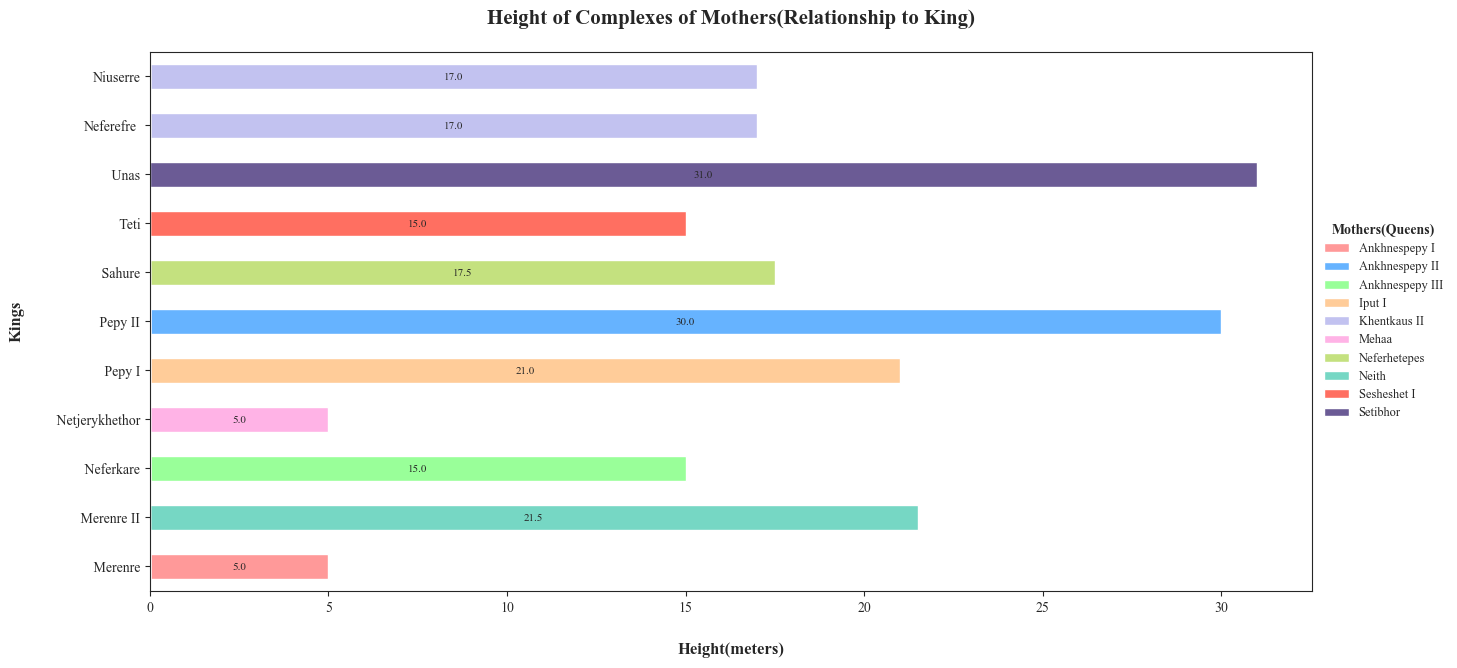

In [101]:
mother_heights = queens_df[['mother_to','height','pyramid_owner']][pd.notna(queens_df['mother_to'])].reset_index(drop=True)
mother_heights.at[1,'mother_to']='Neferefre '
new_niuserre_row={'mother_to':'Niuserre', 'height':17, 'pyramid_owner':'Khentkaus II'}
mother_heights.loc[len(wifes_heights)] = new_niuserre_row
mother_heights

pivot_df = mother_heights.pivot_table(index='mother_to', columns='pyramid_owner', values='height', aggfunc='sum', fill_value=0)
fig, ax = plt.subplots(figsize=(15, 7))
plt.rcParams['font.family'] = 'Times New Roman'
pivot_df = mother_heights.pivot_table(index='mother_to', columns='pyramid_owner', values='height', aggfunc='sum', fill_value=0)

custom_colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6',
               '#c4e17f', '#76d7c4', '#ff6f61', '#6b5b95']
pivot_df.plot(kind='barh', stacked=True, ax=ax, color=custom_colors)

for bars in ax.containers:
    ax.bar_label(bars, label_type='center', fmt='%.1f', fontsize=8)
for text in ax.texts:
        if text.get_text() == '0.0':
            text.set_visible(False)


ax.set_xlabel('Height(meters)',labelpad=20,fontsize=12,fontweight='bold')
ax.set_ylabel('Kings',labelpad=20,fontweight='bold',fontsize=12)
ax.set_title('Height of Complexes of Mothers(Relationship to King)',pad=20,fontsize=15,fontweight='bold')
legend = ax.legend(
        title='Mothers(Queens)', bbox_to_anchor=(1, 0.5), fontsize=9,loc="center left"
    )
legend.get_frame().set_facecolor("white")
legend.get_frame().set_edgecolor("white")
plt.setp(legend.get_title(), fontweight="bold", fontsize=10)

plt.show()

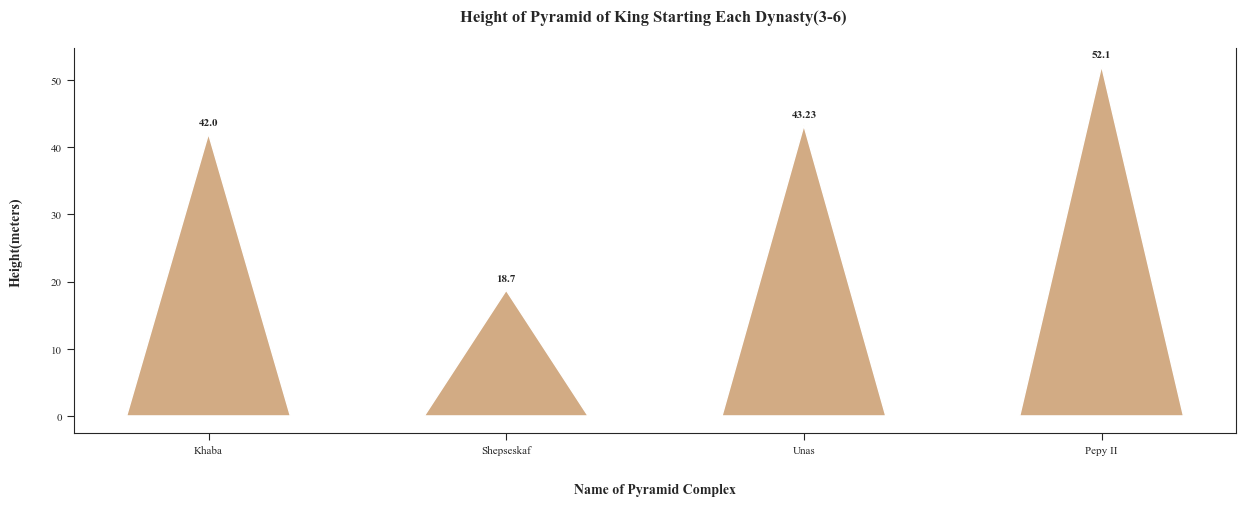

In [70]:
kings_start_reign=df[['dynasty','start_of_reign','pyramid_complex','height','royal_status']][df['royal_status']=='King'].groupby('dynasty')['start_of_reign'].min().reset_index()
min_start_reign = pd.merge(kings_start_reign, df, on=['dynasty', 'start_of_reign'])
min_start_reign=min_start_reign[['dynasty','start_of_reign','pyramid_complex','height','royal_status']][pd.notna(min_start_reign['start_of_reign'])]
fig, ax = plt.subplots(figsize=(15, 5))
sns.set_style(style='ticks')
plt.tick_params(axis='both', which='major', length=5) 
ax.tick_params(axis='both', labelsize=8) 
plt.rcParams['font.family'] = 'Times New Roman'
for i, (category, value) in enumerate(zip(min_start_reign['pyramid_complex'].to_list(), min_start_reign['height'].to_list())):
    ax.fill([i-0.275, i, i+0.275], [0, value, 0], color='#d2ab84', alpha=1, edgecolor='white', linewidth=1.)
    ax.text(i, value + 1, f'{value}', ha='center', va='bottom', fontsize=8, fontweight='bold')
ax.set_xticks(range(len(min_start_reign['pyramid_complex'].to_list())))
ax.set_xticklabels(min_start_reign['pyramid_complex'].to_list())
plt.title('Height of Pyramid of King Starting Each Dynasty(3-6) ',fontweight='bold',pad=20, fontsize=12)
plt.xlabel('Name of Pyramid Complex',fontweight='bold',labelpad=20, fontsize=10)
plt.ylabel('Height(meters)', fontweight='bold',labelpad=20, fontsize=10)
ax.spines['top'].set_visible(False)
plt.show()

In [172]:
complex_cities=df[['site_or_location','casing','superstructure_type','royal_status']][df['site_or_location']!='Unknown']
complex_cities = complex_cities.groupby('site_or_location', sort=False).agg(
    casing=('casing', lambda x: list(set(x))),
    superstructure=('superstructure_type', lambda x: list(set(x))),
    kings_count=('royal_status', lambda x: sum(x == 'King')),
    queens_count=('royal_status', lambda x: sum(x == 'Queen'))
).reset_index()
complex_cities.drop([1,2,6,8], inplace = True)
complex_cities['country']=['Egypt']*5
complex_cities.at[0, 'casing']='Limestone,Granite,Unknown'
complex_cities.at[0,'kings_count']=12
complex_cities.at[0,'queens_count']=19
complex_cities.at[0, 'superstructure']='Pyramid,Mastaba'
complex_cities.at[3, 'casing']='Limestone'
complex_cities.at[3, 'superstructure']='Pyramid'
complex_cities.at[4, 'casing']='Limestone,Granite,Not Cased'
complex_cities.at[4, 'superstructure']='Pyramid'
complex_cities.at[5 ,'casing']='Limestone,Granite'
complex_cities.at[5, 'superstructure']='Pyramid'
complex_cities.at[7, 'casing']='Limestone'
complex_cities.at[7, 'superstructure']='Pyramid'

key = '91fc143d65da4b8ba69d53e153d0fdef'
geocoder = OpenCageGeocode(key)
def geocode_address(row):
    location = geocoder.geocode(f"{row['site_or_location']},{row['country']}")
    if location and len(location):
        return location[0]['geometry']['lat'], location[0]['geometry']['lng']
    else:
        return None, None
complex_cities['latitude'], complex_cities['longitude'] = zip(*complex_cities.apply(geocode_address, axis=1))

complex_cities
complex_cities

,site_or_location,casing,superstructure,kings_count,queens_count,country,latitude,longitude
0,Saqqara,"Limestone,Granite,Unknown","Pyramid,Mastaba",12,19,Egypt,29.850335,31.228284
3,Dahshur,Limestone,Pyramid,2,0,Egypt,29.799041,31.206406
4,Giza,"Limestone,Granite,Not Cased",Pyramid,3,7,Egypt,29.987075,31.211806
5,Abu Roash,"Limestone,Granite",Pyramid,1,0,Egypt,30.044480,31.092690
7,Abusir,Limestone,Pyramid,4,2,Egypt,29.898159,31.208420


In [212]:
complex_cities.reset_index()

egypt_map = folium.Map(location=[ 29.9044,31.2357], zoom_start=11.47)


for index, row in complex_cities.iterrows():
        if 'Saqqara' == row['site_or_location']:
            color = 'lightred'
        elif row['site_or_location'] == 'Zawiyet el-Aryan':
            color = 'red'
        elif row['site_or_location'] == 'Meidum':
            color = 'green'
        elif row['site_or_location'] == 'Dahshur':
            color = 'darkred'
        elif row['site_or_location'] == 'Giza':
            color = 'blue'
        elif row['site_or_location'] == 'Abu Roash':
            color = 'purple'
        else:
            color = 'darkblue'
        #popup_text = f"Site:<br> {row['site_or_location']}<br><br>Number of Complexes:<br> {row['complex_count']}<br><br>Superstructure Type:<br>{row['superstructure']}<br><br>Casing:<br> {row['casing']}<br><br>Kings Count:<br> {row['kings_count']}<br><br>Queens Count:<br> {row['queens_count']}"
        # folium.Marker((row['latitude'], row['longitude']), icon=folium.Icon(color=color),popup=popup_text).add_to(egypt_map)
        folium.Marker(
            [row['latitude'], row['longitude']], 
            icon=folium.Icon(color=color)
        ).add_to(egypt_map)
        folium.map.Marker(
            [row['latitude'], row['longitude']],
            icon=folium.DivIcon(
                icon_size=(150,36),
                icon_anchor=(0,0),
                html=f"""
                <div style="font-size: 8px; color: {color};font-weight: bold">
                <b>Site:{row['site_or_location']}<br>
                Superstructure Type:{row['superstructure']}<br>
                Casing:{row['casing']}<br>
                Kings #:<br>{row['kings_count']}<br>
                Queens #: <br>{row['queens_count']}<br>
                </div>
                """
            )
        ).add_to(egypt_map)

egypt_map 


